In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 闵可夫斯基距离

In [2]:
def mk_dist(v1, v2, p=2, ax=0):
    """
    Minkowski distance
    """
    return (((v1 - v2)**p).sum(axis=ax))**(1/p)

In [3]:
x5 = np.array([0.556, 0.215])
x1 = np.array([0.697, 0.460])

mk_dist(x1, x5)

0.2826764935398767

# 西瓜数据集4.0

In [4]:
watermelon4 = pd.DataFrame({
    "density":[
         0.697, 0.774, 0.634, 0.608, 0.556, 0.403, 0.481, 0.437, 0.666, 0.243,
         0.245, 0.343, 0.639, 0.657, 0.360, 0.593, 0.719, 0.359, 0.339, 0.282,
         0.748, 0.714, 0.483, 0.478, 0.525, 0.751, 0.532, 0.473, 0.725, 0.446
    ],
    "sugar_content": [
         0.460, 0.376, 0.264, 0.318, 0.215, 0.237, 0.149, 0.211, 0.091, 0.267,
         0.057, 0.099, 0.161, 0.198, 0.370, 0.042, 0.103, 0.188, 0.241, 0.257,
         0.232, 0.346, 0.312, 0.437, 0.369, 0.489, 0.472, 0.376, 0.445, 0.459
    ]
})

watermelon4.index = watermelon4.index+1

In [5]:
watermelon4.head()

,density,sugar_content
1,0.697,0.460
2,0.774,0.376
3,0.634,0.264
4,0.608,0.318
5,0.556,0.215


# k-means聚类  
原型聚类

In [6]:
def k_means(df, k):
    """
    TODO!!!:
    df["cluster"] = label_lst
    will change ORIGINAL DataFrame, so need df.copy() as param

    k-means clustering
    df:  pd.DataFrame
    k:   number of clusters

    return:
        cluster labels
    """
    # initial vector mu in ML book
    # df_vector_mu = pd.DataFrame({
    #     "density": [0.403, 0.343, 0.478],
    #     "sugar_content": [0.237, 0.099, 0.437]
    # })

    # initiate vector mu
    df_vector_mu = df.sample(k)
    df_vector_mu.index = range(k)
    # set cluster label for each sample
    label_lst = []
    # TODO !!! optimized by df.apply()
    for idx in range(len(df)):
        xi = df.iloc[idx]
        df_dist = mk_dist(xi, df_vector_mu, ax=1)
        label = df_dist.idxmin()
        label_lst.append(label)
    df["cluster"] = label_lst
    
    # update vector mu
    all_updated = True
    while all_updated:
        update_list = []
        mu_updated = True
        for label in range(k):
            new_mu = df[df["cluster"]==label].iloc[:, :-1].mean()
            # compare pd.Series by s1.equals(s2)
            if df_vector_mu.iloc[label].equals(new_mu):
                mu_updated = False
            else:
                df_vector_mu.iloc[label] = new_mu
                mu_updated = True
            update_list.append(mu_updated)
        
        # check whether all the mu have been updated
        if (sum(update_list) == 0):
            all_updated = False
        else:
            all_updated = True
        
        # update cluster label
        if all_updated:        
            label_lst = []
            for idx in range(len(df)):
                xi = df.iloc[idx, :-1]
                df_dist = mk_dist(xi, df_vector_mu, ax=1)
                label = df_dist.idxmin()
                label_lst.append(label)
            # df["cluster"] = label_lst
    cluster_labels = pd.Series(label_lst, index=df.index)
            
    return cluster_labels

k=4聚类结果

In [7]:
df_kmeans = watermelon4.copy()
cluster_labels = k_means(df_kmeans, 4)
df_kmeans["cluster"] = cluster_labels

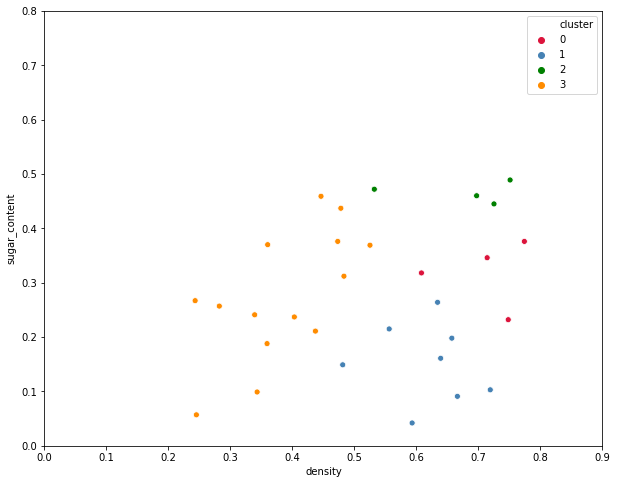

In [8]:
plt.figure(figsize=(10, 8))
colors = {
    0: "#DC143C", 1: "#4682B4", 2: "green", 3: "#FF8C00"
}
sns.scatterplot(x="density", y="sugar_content", hue="cluster", data=df_kmeans, palette=colors, sizes=20)
plt.xlim([0, 0.9])
plt.ylim([0, 0.8])
plt.show()

# 密度聚类

In [9]:
class Queue(object):
    def __init__(self, lst):
        """
        lst: []
        """
        self.items = lst
    
    def status(self):
        return self.items
    
    def is_empty(self):
        empty = True
        if len(self.items) != 0:
            empty = False
        return empty
    
    def en_queue(self, item):
        return self.items.insert(0, item)
        
    def de_queue(self):
        return self.items.pop()
    
    def size(self):
        return len(self.items)


def core_object(df, epsilon=0.11, min_pts=5):
    """
    find core object s.t. epsilon, min_pts
    return:
        core_object's index in df
    """
    core = set()
    for idx in df.index:
        df_dist = mk_dist(df.loc[idx], df, ax=1)
        pts = (df_dist <= epsilon).sum()
        if pts >= min_pts:
            core.add(idx)
    return core


def neighborhood(df, i, epsilon=0.11, min_pts=5):
    """
    find core_object's directly density-reachable, here is called neighbor
    return:
        neighbor's index
    """
    df_dist = mk_dist(df.loc[i], df, ax=1)
    return df[df_dist <= epsilon].index


def dbscan(df, epsilon=0.11, min_pts=5):
    """
    DBSCAN algorithm
    return:
        cluster labels, 0 means NO group
    """
    max_round = 1000
    cluster_dict = {}
    core = core_object(df)

    k = 0
    no_visits = set(df.index)

    while (len(core) != 0) and max_round > 0:
        no_visits_old = no_visits
        c_obj = random.choice(tuple(core))
        queue = Queue([c_obj,])
        # no_visits.discard(c_obj)
        while (not queue.is_empty()):
            q = queue.de_queue()
            neighbor = neighborhood(df, q)
            if len(neighbor) >= min_pts:
                s = set(neighbor)
                delta = s.intersection(no_visits)
                for d in delta:
                    queue.en_queue(d)
                no_visits = no_visits.difference(delta)
        k += 1
        cluster = no_visits_old.difference(no_visits)
        for c in cluster:
            cluster_dict[c] = k
        core = core.difference(cluster)
        max_round -= 1
    
    cluster_labels = pd.Series(
        [cluster_dict.get(idx, 0) for idx in df.index], index=df.index
    )
        
    return cluster_labels


聚类结果

In [10]:
cluster_labels = dbscan(watermelon4)
df_dbscan = watermelon4.copy()
df_dbscan["cluster"] = cluster_labels

In [11]:
cluster_labels.unique()

array([3, 2, 1, 0, 4], dtype=int64)

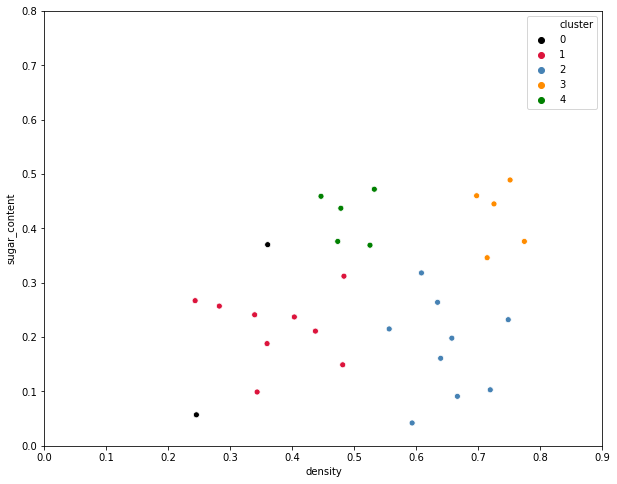

In [12]:
plt.figure(figsize=(10, 8))
colors = {
    1: "#DC143C", 2: "#4682B4", 3: "#FF8C00", 4: "green", 0: "black"
}
sns.scatterplot(x="density", y="sugar_content", hue="cluster", data=df_dbscan, palette=colors, sizes=20)
plt.xlim([0, 0.9])
plt.ylim([0, 0.8])
plt.show()

# 层次聚类

In [13]:
def haus_dist(c1, c2, method="mean"):
    """
    TODO!!!: mask diagonal if c1 and c2 are the same matrix
    method: one of ["mean", "max", "min"]
    """
    # check type of cluster1 and cluster2
    dist_matrix = pd.DataFrame()
    c1_type = type(c1)
    c2_type = type(c2)
    # according type of c1,c2, calculate dist_mat
    # if isinstance(c1, pd.DataFrame) and isinstance(c2, pd.DataFrame):
    if (c1_type is pd.DataFrame) and (c2_type is pd.DataFrame):
        dist_matrix = c1.apply(lambda x: mk_dist(x, c2, ax=1), axis=1)
    elif (c1_type is pd.Series) and (c2_type is pd.Series):
        dist_matrix = mk_dist(c1, c2, ax=1)
    else:
        dist_matrix = mk_dist(c1, c2, ax=0)
    
    # according type of c1,c2 and method of haus_dist, calculate distance
    distance = 0.0
    dist_mat_type = type(dist_matrix)
    if dist_mat_type is float:
        return dist_matrix
    
    if method == "mean":
        distance = (dist_matrix.mean().mean() 
                if dist_mat_type is pd.DataFrame else dist_matrix.mean())
    elif method == "max":
        distance = (dist_matrix.max().max() 
                if dist_mat_type is pd.DataFrame else dist_matrix.max())
    elif method == "min":
        distance = (dist_matrix.min().min() 
                if dist_mat_type is pd.DataFrame else dist_matrix.min())
    else:
        print("method wrong ! [mean|max|min]")
    
    return distance


def update_cluster_dict(cluster_labels):
    cluster_dict = {}
    labels = cluster_labels.values
    indexes = cluster_labels.index
    for i in range(len(cluster_labels)):
        cluster_dict.setdefault(labels[i], set()).add(indexes[i])
    return cluster_dict

    
def agnes(df, k, haus="mean"):
    """
    AGNES algorithm, bottom-up hierachical clustering
    k: number of clusters
    haus_dist: one of ["mean", "max", "min"]
    
    cluster_dict = {
        label1: {idx1, idx3},
        label2: {idx2, idx5},
    }
    """
    cluster_dict = {}
    # initiate cluster labels
    labels = range(1, len(df)+1)
    cluster_labels = pd.Series(labels, index=df.index)
    # initiate distance matrix
    dist_matrix = df.apply(lambda x: mk_dist(x, df, ax=1), axis=1)
    dist_matrix.index = labels
    dist_matrix.columns = labels
    
    m = len(df)
    while m > k:
        # mask diagonal element
        dist_mat_mask = dist_matrix.mask(np.eye(len(dist_matrix), dtype=bool))
        # find min value's (row, column)name in dist_mat_mask, 
        # merge these 2 clusters into 1
        c1_label, c2_label = dist_mat_mask.stack().idxmin()
        # update cluster label
        cluster_labels[cluster_labels.values==c2_label] = c1_label
        cluster_dict = update_cluster_dict(cluster_labels)
        # update dist_matrix
        dist_matrix = dist_matrix.drop(index=c2_label, columns=c2_label)
        # TODO !!! : try to vectorize
        cols = dist_matrix.columns
        for row_label in dist_matrix.index:
            cols = cols.drop(row_label)
            for col_label in cols:
                row_cluster = df.loc[cluster_dict[row_label]]
                col_cluster = df.loc[cluster_dict[col_label]]
                distance = haus_dist(row_cluster, col_cluster, method=haus)
                dist_matrix.loc[row_label, col_label] = distance
                dist_matrix.loc[col_label, row_label] = distance
        m -= 1
    # rename label as 1 to k
    for label, idx_set in cluster_dict.items():
        cluster_labels.loc[idx_set] = k
        k -= 1

    return cluster_labels

k=4聚类结果

In [14]:
cluster_labels_hier = agnes(watermelon4, 4, haus="max")
df_agnes = watermelon4.copy()
df_agnes["cluster"] = cluster_labels_hier
cluster_labels_hier.unique()

array([4, 3, 2, 1], dtype=int64)

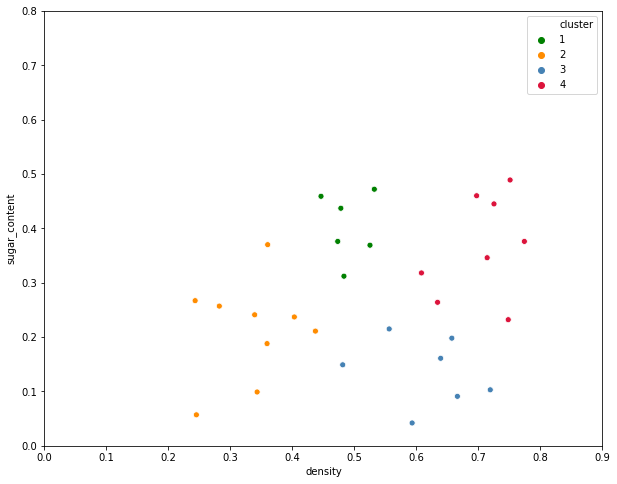

In [15]:
plt.figure(figsize=(10, 8))
 
colors = {
    4: "#DC143C", 3: "#4682B4", 2: "#FF8C00", 1: "green"
}
sns.scatterplot(x="density", y="sugar_content", hue="cluster", data=df_agnes, palette=colors, sizes=20)
plt.xlim([0, 0.9])
plt.ylim([0, 0.8])
plt.show()